In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


# 1. ЗАГРУЗКА И АНАЛИЗ ДАТАСЕТА DIAMONDS


Размер датасета: (53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


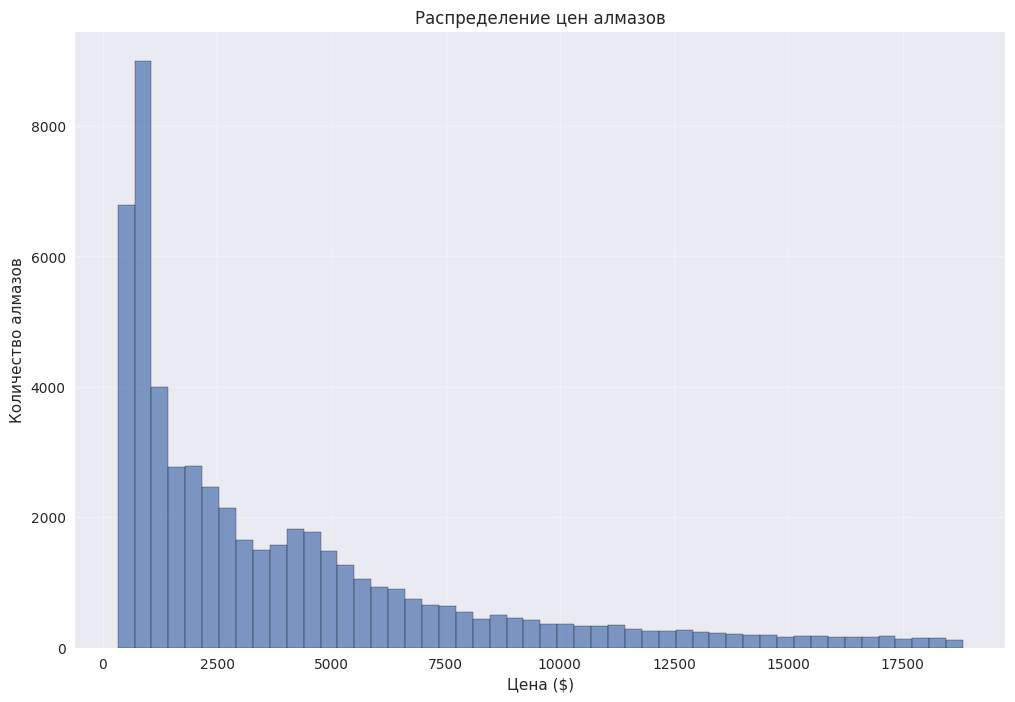

In [5]:
diamonds = sns.load_dataset('diamonds')

print(f"Размер датасета: {diamonds.shape}")
diamonds.info()
diamonds.describe()

plt.hist(diamonds['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен алмазов')
plt.xlabel('Цена ($)')
plt.ylabel('Количество алмазов')
plt.grid(True, alpha=0.3)
plt.show()


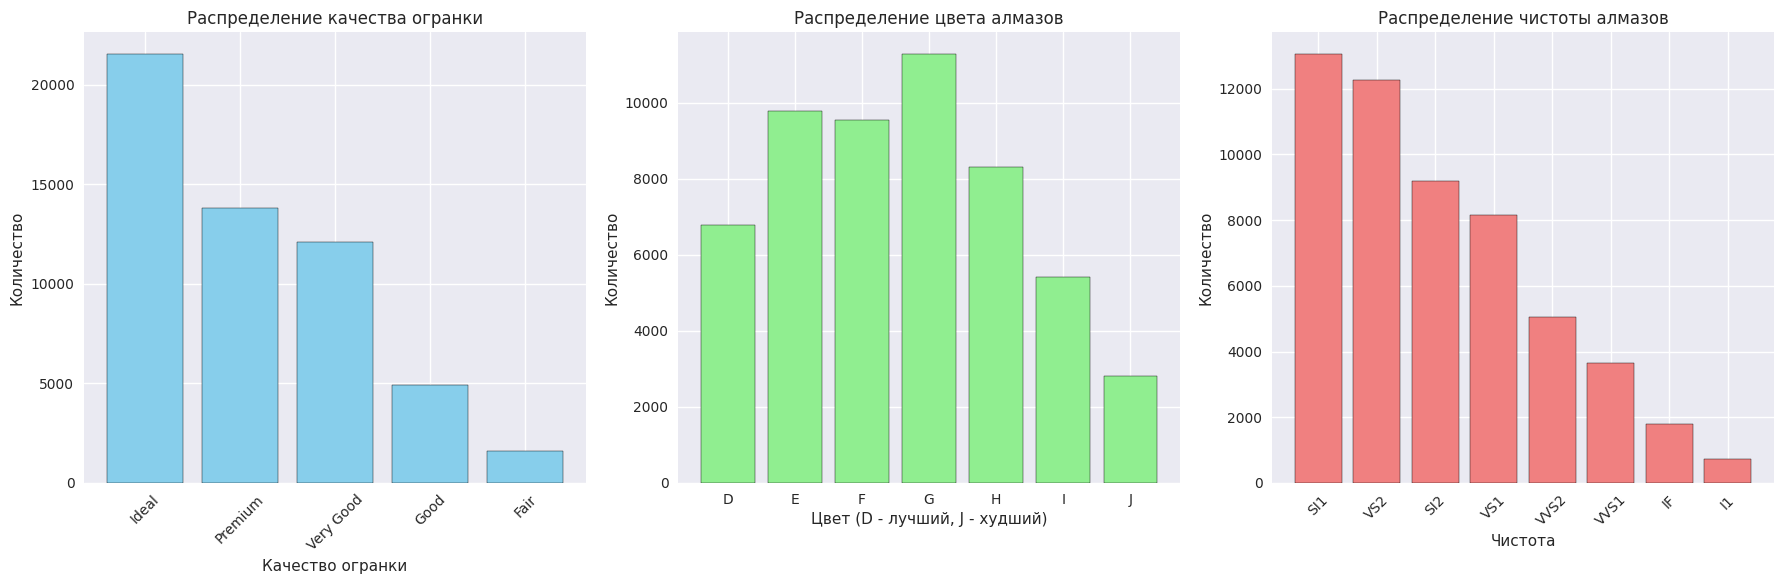

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cut_counts = diamonds['cut'].value_counts()
axes[0].bar(cut_counts.index, cut_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение качества огранки')
axes[0].set_xlabel('Качество огранки')
axes[0].set_ylabel('Количество')
axes[0].tick_params(axis='x', rotation=45)

color_counts = diamonds['color'].value_counts().sort_index()
axes[1].bar(color_counts.index, color_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_title('Распределение цвета алмазов')
axes[1].set_xlabel('Цвет (D - лучший, J - худший)')
axes[1].set_ylabel('Количество')

clarity_counts = diamonds['clarity'].value_counts()
axes[2].bar(clarity_counts.index, clarity_counts.values, color='lightcoral', edgecolor='black')
axes[2].set_title('Распределение чистоты алмазов')
axes[2].set_xlabel('Чистота')
axes[2].set_ylabel('Количество')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


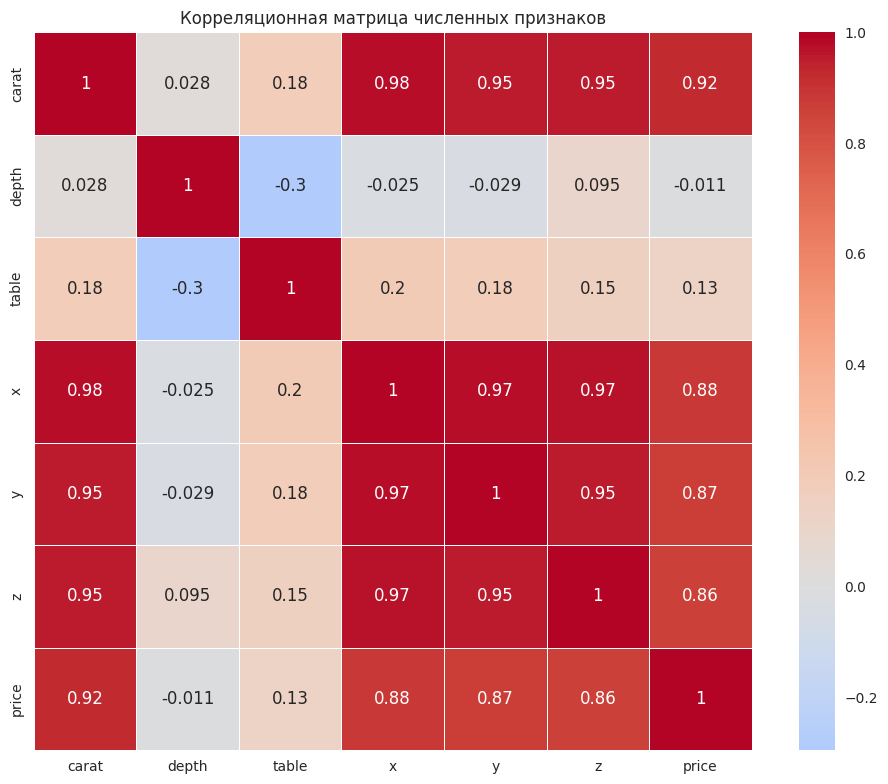

In [8]:
numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
correlation_matrix = diamonds[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Корреляционная матрица численных признаков')
plt.tight_layout()
plt.show()


# 2. ПРЕДОБРАБОТКА ДАННЫХ


In [9]:
data = diamonds.copy()

le_cut = LabelEncoder()
le_color = LabelEncoder()
le_clarity = LabelEncoder()

data['cut_encoded'] = le_cut.fit_transform(data['cut'])
data['color_encoded'] = le_color.fit_transform(data['color'])
data['clarity_encoded'] = le_clarity.fit_transform(data['clarity'])

print("Кодировка категорий:")
cut_dict = dict(zip(le_cut.classes_, range(len(le_cut.classes_))))
color_dict = dict(zip(le_color.classes_, range(len(le_color.classes_))))
clarity_dict = dict(zip(le_clarity.classes_, range(len(le_clarity.classes_))))
print(f"Cut: {cut_dict}")
print(f"Color: {color_dict}")
print(f"Clarity: {clarity_dict}")

print(data[['cut', 'cut_encoded', 'color', 'color_encoded', 'clarity', 'clarity_encoded', 'price']].head())


Кодировка категорий:
Cut: {'Fair': 0, 'Good': 1, 'Ideal': 2, 'Premium': 3, 'Very Good': 4}
Color: {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}
Clarity: {'I1': 0, 'IF': 1, 'SI1': 2, 'SI2': 3, 'VS1': 4, 'VS2': 5, 'VVS1': 6, 'VVS2': 7}
       cut  cut_encoded color  color_encoded clarity  clarity_encoded  price
0    Ideal            2     E              1     SI2                3    326
1  Premium            3     E              1     SI1                2    326
2     Good            1     E              1     VS1                4    327
3  Premium            3     I              5     VS2                5    334
4     Good            1     J              6     SI2                3    335


In [10]:
feature_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_encoded', 'color_encoded', 'clarity_encoded']
X = data[feature_cols]

y = data['price']

print(f"Признаки (X): {list(X.columns)}")
print(f"Размер X: {X.shape}")
print(f"Целевая переменная (y): price")
print(f"Размер y: {y.shape}")


Признаки (X): ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_encoded', 'color_encoded', 'clarity_encoded']
Размер X: (53940, 9)
Целевая переменная (y): price
Размер y: (53940,)


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Статистика после нормализации:")
print(X_scaled.describe().round(3))


Статистика после нормализации:
           carat      depth      table          x          y          z  \
count  53940.000  53940.000  53940.000  53940.000  53940.000  53940.000   
mean       0.000      0.000      0.000      0.000     -0.000      0.000   
std        1.000      1.000      1.000      1.000      1.000      1.000   
min       -1.261    -13.088     -6.470     -5.109     -5.021     -5.015   
25%       -0.840     -0.523     -0.652     -0.910     -0.888     -0.891   
50%       -0.207      0.035     -0.205     -0.028     -0.021     -0.012   
75%        0.511      0.524      0.690      0.721      0.705      0.710   
max        8.886     12.041     16.802      4.465     46.550     40.048   

       cut_encoded  color_encoded  clarity_encoded  
count    53940.000      53940.000        53940.000  
mean         0.000         -0.000           -0.000  
std          1.000          1.000            1.000  
min         -2.484         -1.525           -2.224  
25%         -0.538         -

Обучающая выборка: X_train=(43152, 9), y_train=(43152,)
Тестовая выборка: X_test=(10788, 9), y_test=(10788,)
Размер тестовой выборки: 10788 образцов (20.0%)


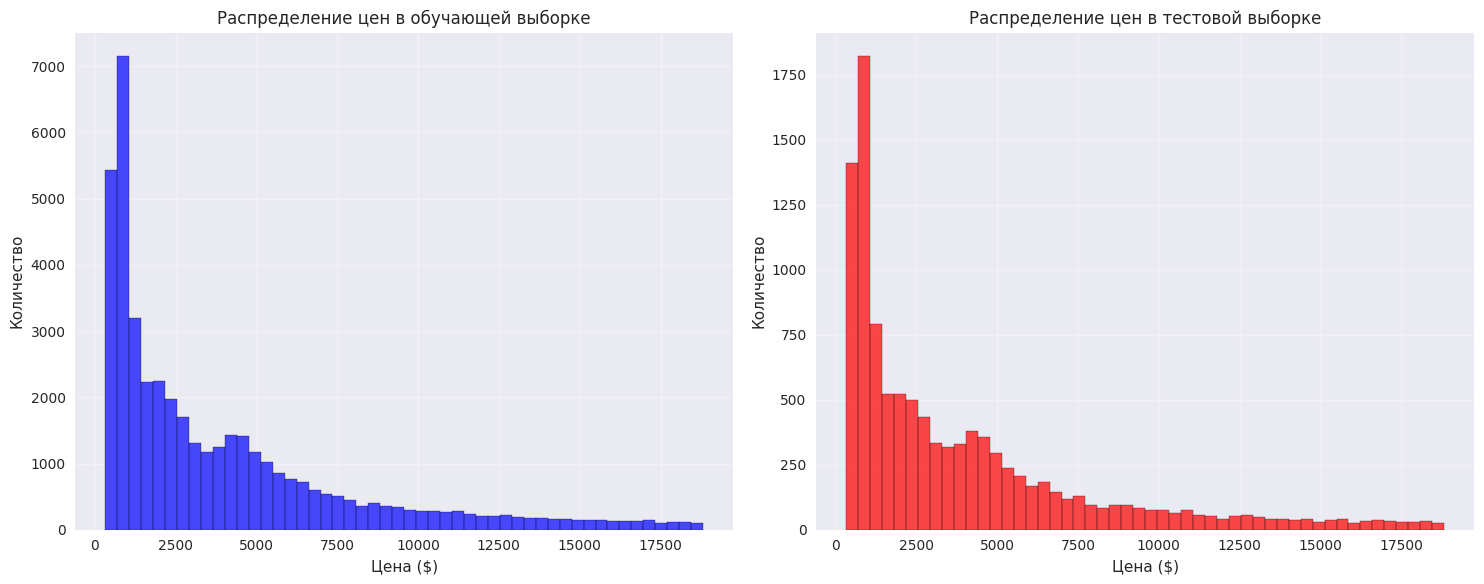

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Тестовая выборка: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Размер тестовой выборки: {len(X_test)} образцов ({100*len(X_test)/(len(X_train)+len(X_test)):.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(y_train, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Распределение цен в обучающей выборке')
axes[0].set_xlabel('Цена ($)')
axes[0].set_ylabel('Количество')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_test, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].set_title('Распределение цен в тестовой выборке')
axes[1].set_xlabel('Цена ($)')
axes[1].set_ylabel('Количество')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 3. СОЗДАНИЕ НЕЙРОННОЙ СЕТИ ДЛЯ РЕГРЕССИИ


In [13]:
class DiamondsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiamondsDataset(X_train, y_train)
test_dataset = DiamondsDataset(X_test, y_test)

print(f"Создан обучающий датасет: {len(train_dataset)} образцов")
print(f"Создан тестовый датасет: {len(test_dataset)} образцов")

sample_X, sample_y = train_dataset[0]
print(f"Пример данных: Признаки: {sample_X}, Цена: ${sample_y.item():.0f}")


Создан обучающий датасет: 43152 образцов
Создан тестовый датасет: 10788 образцов
Пример данных: Признаки: tensor([ 2.5571, -2.5474,  2.9281,  2.2276,  2.1499,  1.7448, -1.5111, -0.3493,
        -0.4843]), Цена: $16231


In [14]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoader создан с размером батча: {batch_size}")
print(f"Количество батчей в обучении: {len(train_loader)}")
print(f"Количество батчей в тесте: {len(test_loader)}")

batch_X, batch_y = next(iter(train_loader))
print(f"Пример батча: Размер X: {batch_X.shape}, Размер y: {batch_y.shape}")


DataLoader создан с размером батча: 64
Количество батчей в обучении: 675
Количество батчей в тесте: 169
Пример батча: Размер X: torch.Size([64, 9]), Размер y: torch.Size([64, 1])


In [15]:
class DiamondPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(DiamondPricePredictor, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

input_size = X_train.shape[1]
model = DiamondPricePredictor(input_size)

print(f"Создана нейронная сеть: {input_size} -> 128 -> 64 -> 32 -> 1")

with torch.no_grad():
    sample_output = model(batch_X[:5])
    print(f"Пример предсказаний: {sample_output.flatten()}")
    print("(Предсказания случайные, так как модель не обучена)")


Создана нейронная сеть: 9 -> 128 -> 64 -> 32 -> 1
Пример предсказаний: tensor([ 0.1405, -0.0047,  0.1134, -0.0715,  0.0492])
(Предсказания случайные, так как модель не обучена)


In [16]:
criterion = nn.MSELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
optimizer.zero_grad()

outputs = model(batch_X)
loss = criterion(outputs, batch_y)

print(f"Функция потерь: MSE")
print(f"Оптимизатор: Adam с learning rate = {learning_rate}")
print(f"Потери на случайной модели: {loss.item():.2f}")


Функция потерь: MSE
Оптимизатор: Adam с learning rate = 0.001
Потери на случайной модели: 26875656.00


# 4. ОБУЧЕНИЕ МОДЕЛИ


Начинаем обучение на 50 эпохах...
Эпоха [10/50]:
  Train Loss: 1521267.3143
  Test Loss: 1201392.0359
Эпоха [20/50]:
  Train Loss: 1425030.3992
  Test Loss: 1159451.5741
Эпоха [30/50]:
  Train Loss: 1414115.8539
  Test Loss: 1146736.4630
Эпоха [40/50]:
  Train Loss: 1371021.0419
  Test Loss: 1134490.7186
Эпоха [50/50]:
  Train Loss: 1376494.0175
  Test Loss: 1131540.2567
Обучение завершено!
Финальные результаты: Train Loss: 1376494.0175, Test Loss: 1131540.2567


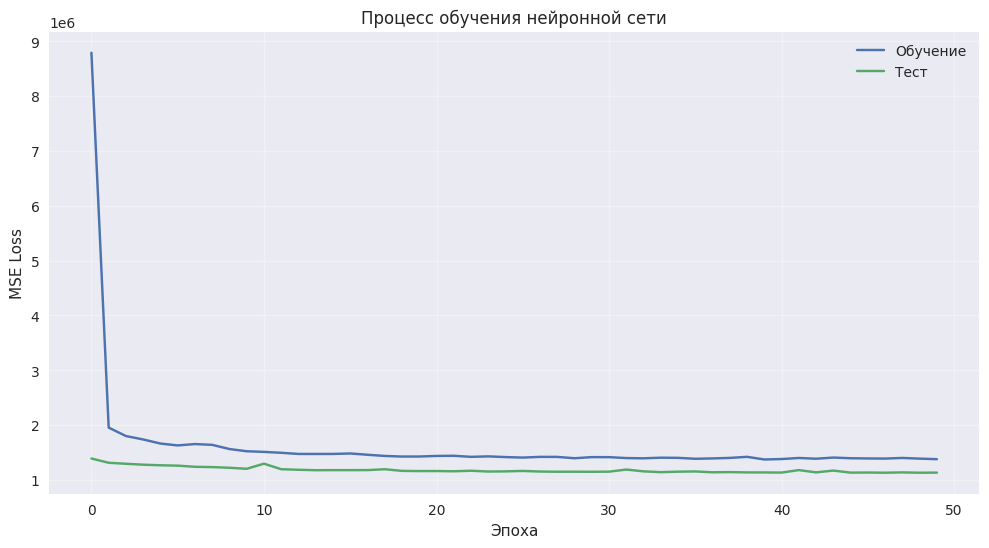

In [17]:
num_epochs = 50
train_losses = []
test_losses = []

print(f"Начинаем обучение на {num_epochs} эпохах...")

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_test_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Test Loss: {avg_test_loss:.4f}")

print("Обучение завершено!")
print(f"Финальные результаты: Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Обучение')
plt.plot(test_losses, label='Тест')
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.title('Процесс обучения нейронной сети')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 5. ОЦЕНКА КАЧЕСТВА МОДЕЛИ


In [18]:
model.eval()
all_predictions = []
all_true_values = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        all_predictions.extend(outputs.numpy().flatten())
        all_true_values.extend(batch_y.numpy().flatten())

y_pred = np.array(all_predictions)
y_true = np.array(all_true_values)

print(f"Получено предсказаний: {len(y_pred)}")

print("Примеры предсказаний:")
for i in range(5):
    pred = y_pred[i]
    true = y_true[i]
    error = abs(pred - true)
    print(f"Образец {i+1}: Предсказано ${pred:.0f}, Истинная ${true:.0f}, Ошибка ${error:.0f}")


Получено предсказаний: 10788
Примеры предсказаний:
Образец 1: Предсказано $624, Истинная $559, Ошибка $65
Образец 2: Предсказано $2559, Истинная $2201, Ошибка $358
Образец 3: Предсказано $1350, Истинная $1238, Ошибка $112
Образец 4: Предсказано $1516, Истинная $1304, Ошибка $212
Образец 5: Предсказано $12079, Истинная $6901, Ошибка $5178


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_true, y_pred)

r2 = r2_score(y_true, y_pred)

print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ:")
print("=" * 30)
print(f"MSE: {mse:.2f}")
# print(f"RMSE: ${rmse:.2f}")
# print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")
print("=" * 30)

mean_price = y_true.mean()
naive_mae = mean_absolute_error(y_true, [mean_price] * len(y_true))
print(f"Сравнение с наивной моделью:")
print(f"Наша модель MAE: ${mae:.0f}")
print(f"Наивная модель MAE: ${naive_mae:.0f}")
print(f"Улучшение: {((naive_mae - mae) / naive_mae * 100):.1f}%")


МЕТРИКИ КАЧЕСТВА МОДЕЛИ:
MSE: 1131473.12
R² Score: 0.9288
Сравнение с наивной моделью:
Наша модель MAE: $570
Наивная модель MAE: $3011
Улучшение: 81.1%


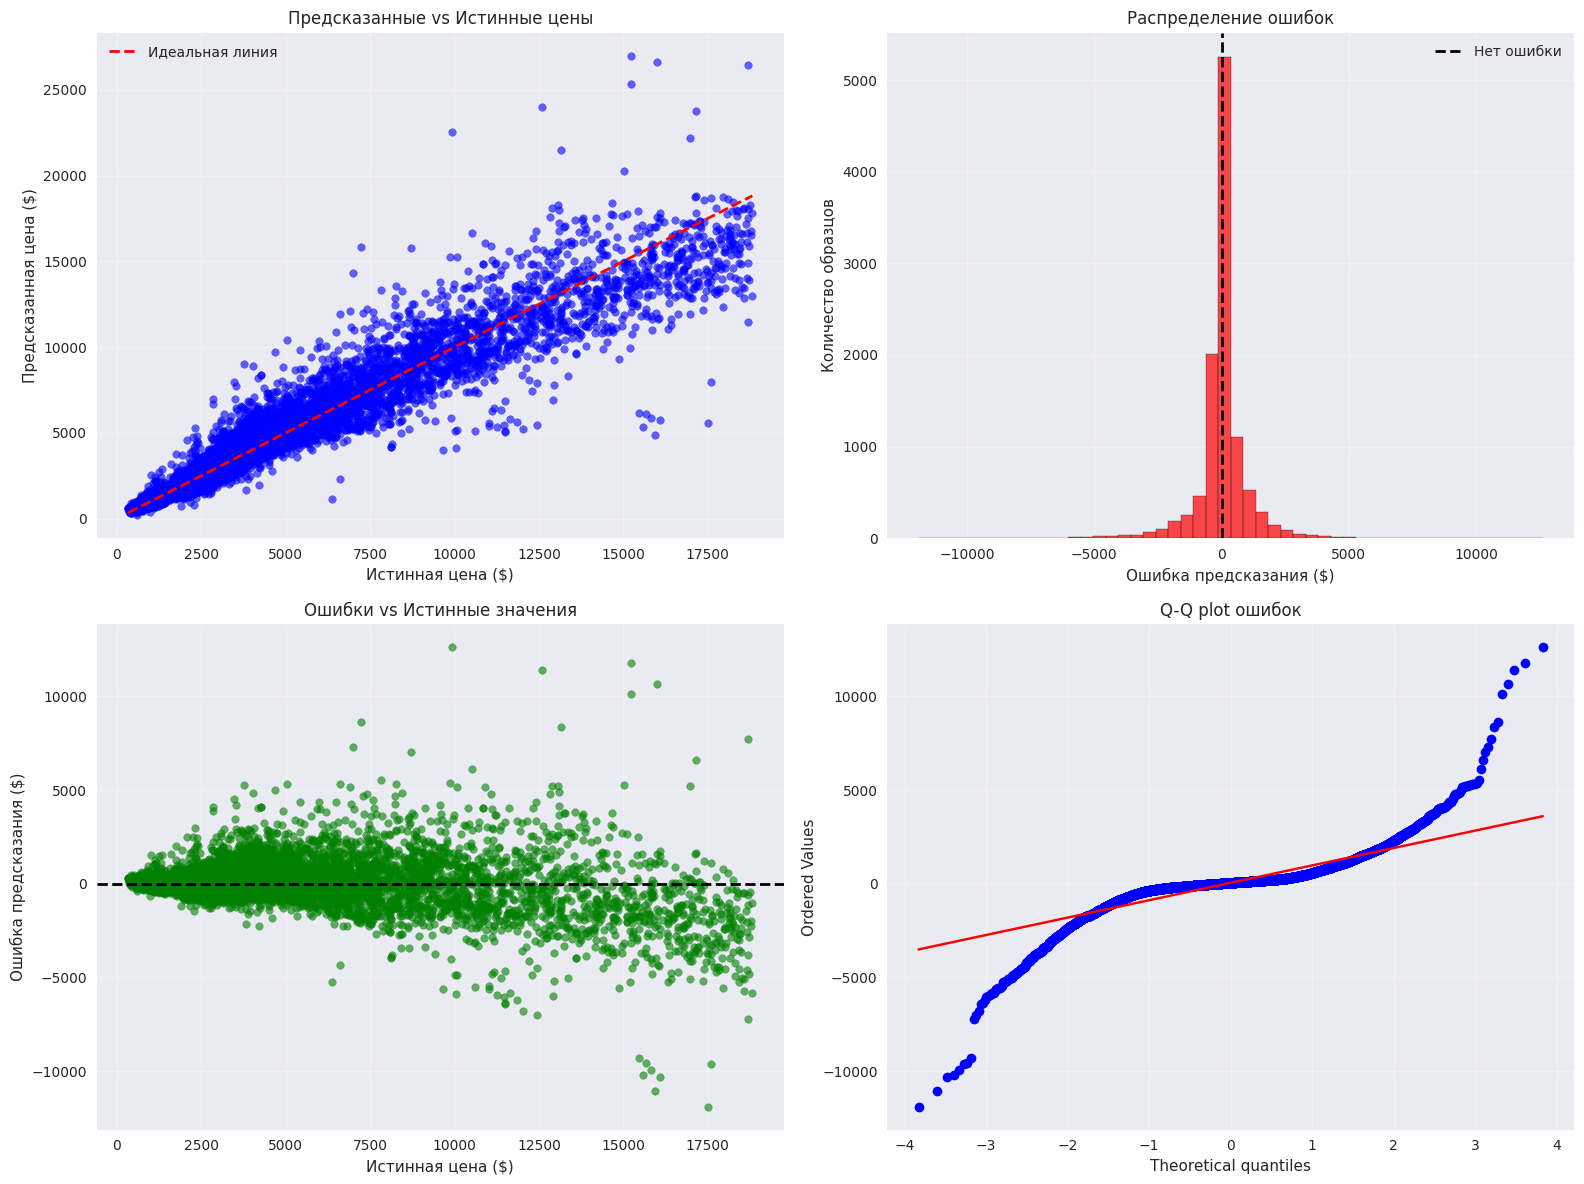

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0,0].scatter(y_true, y_pred, alpha=0.6, color='blue', s=30)
axes[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
               'r--', linewidth=2, label='Идеальная линия')
axes[0,0].set_xlabel('Истинная цена ($)')
axes[0,0].set_ylabel('Предсказанная цена ($)')
axes[0,0].set_title('Предсказанные vs Истинные цены')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

errors = y_pred - y_true
axes[0,1].hist(errors, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,1].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Нет ошибки')
axes[0,1].set_xlabel('Ошибка предсказания ($)')
axes[0,1].set_ylabel('Количество образцов')
axes[0,1].set_title('Распределение ошибок')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].scatter(y_true, errors, alpha=0.6, color='green', s=30)
axes[1,0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1,0].set_xlabel('Истинная цена ($)')
axes[1,0].set_ylabel('Ошибка предсказания ($)')
axes[1,0].set_title('Ошибки vs Истинные значения')
axes[1,0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(errors, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q plot ошибок')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
